In [1]:
import numpy as np
import pandas as pd
import os
import math
import matplotlib.pyplot as plt
import re
from random import randint, seed
from IPython.display import display
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score, mean_squared_error
import warnings
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import plotly.express as px

# Import du dataset

In [2]:
path = 'maladie_cardiaque.csv'
maladie = pd.read_csv(path,sep=',',header=0, index_col=1)
maladie = maladie.drop(columns=['Unnamed: 0'])
maladie.head(5)

,age,genre,taille,Poids,pression_systo,pression_diasto,cholesterol,glycemie,fumeur,conso_alco,activite_physique,malade
id,,,,,,,,,,,,
0,18393,homme,168,62.0,110,80,normal,1,non fumeur,non,1,non
1,20228,femme,156,85.0,140,90,tres eleve,1,non fumeur,non,1,oui
2,18857,femme,165,64.0,130,70,tres eleve,1,non fumeur,non,0,oui
3,17623,homme,169,82.0,150,100,normal,1,non fumeur,non,1,oui
4,17474,femme,156,56.0,100,60,normal,1,non fumeur,non,0,non


# Analyse superficielle du dataset

In [3]:
from data_analyzer import analyse

resultat = analyse(maladie)
display(resultat)

(70000, 12)

,Name,dtypes,Missing,Miss_Percent,Unique,First Value,Second Value,Third Value
0,age,int64,0,0.0,8076,18393,20228,18857
1,genre,object,0,0.0,2,homme,femme,femme
2,taille,int64,0,0.0,109,168,156,165
3,Poids,float64,0,0.0,287,62.0,85.0,64.0
4,pression_systo,int64,0,0.0,153,110,140,130
5,pression_diasto,int64,0,0.0,157,80,90,70
6,cholesterol,object,0,0.0,3,normal,tres eleve,tres eleve
7,glycemie,int64,0,0.0,3,1,1,1
8,fumeur,object,0,0.0,2,non fumeur,non fumeur,non fumeur
9,conso_alco,object,0,0.0,2,non,non,non


In [4]:
maladie.describe()

,age,taille,Poids,pression_systo,pression_diasto,glycemie,activite_physique
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,19468.865814,164.359229,74.205690,128.817286,96.630414,1.226457,0.803729
std,2467.251667,8.210126,14.395757,154.011419,188.472530,0.572270,0.397179
min,10798.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,0.000000
25%,17664.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000
50%,19703.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000
75%,21327.000000,170.000000,82.000000,140.000000,90.000000,1.000000,1.000000
max,23713.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,1.000000


# Data Prep

Création d'une colonne pour avoir l'âge en année

In [5]:
maladie["Age(year)"] = maladie["age"]/365

Ajout d'une colonne avec l'IMC des individus

In [6]:
maladie["IMC"] = maladie['Poids']/((maladie['taille']/100)*(maladie['taille']/100))
maladie

,age,genre,taille,Poids,pression_systo,pression_diasto,cholesterol,glycemie,fumeur,conso_alco,activite_physique,malade,Age(year),IMC
id,,,,,,,,,,,,,,
0,18393,homme,168,62.0,110,80,normal,1,non fumeur,non,1,non,50.391781,21.967120
1,20228,femme,156,85.0,140,90,tres eleve,1,non fumeur,non,1,oui,55.419178,34.927679
2,18857,femme,165,64.0,130,70,tres eleve,1,non fumeur,non,0,oui,51.663014,23.507805
3,17623,homme,169,82.0,150,100,normal,1,non fumeur,non,1,oui,48.282192,28.710479
4,17474,femme,156,56.0,100,60,normal,1,non fumeur,non,0,non,47.873973,23.011177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99993,19240,homme,168,76.0,120,80,normal,1,fumeur,non,1,non,52.712329,26.927438
99995,22601,femme,158,126.0,140,90,eleve,2,non fumeur,non,1,oui,61.920548,50.472681
99996,19066,homme,183,105.0,180,90,tres eleve,1,non fumeur,oui,0,oui,52.235616,31.353579


Binarisation des données

In [7]:
label_encoder_sex = LabelEncoder()
label_encoder_bin = LabelEncoder()

# Encodage binaire des données catégorielles
maladie['genre'] = label_encoder_sex.fit_transform(maladie['genre'])
maladie['conso_alco'] = label_encoder_bin.fit_transform(maladie['conso_alco'])
maladie['fumeur'] = label_encoder_bin.fit_transform(maladie['fumeur'])
maladie['malade'] = label_encoder_bin.fit_transform(maladie['malade'])

C:\Users\alain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\alain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\alain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\alain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra

In [8]:
# Code pour récupérer les données d'origines
# maladie['genre'] = label_encoder_sex.inverse_transform(maladie['genre'])
# display(maladie[['genre']])

In [9]:
print(label_encoder_sex.inverse_transform(maladie['genre']))
print(label_encoder_bin.inverse_transform(maladie['fumeur']))

['homme' 'femme' 'femme' ... 'homme' 'femme' 'femme']
['oui' 'oui' 'oui' ... 'oui' 'oui' 'oui']


C:\Users\alain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\alain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\alain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\alain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra

Caractérisation de l'IMC

In [10]:
maladie.drop_duplicates(inplace=True)
labels = ['Sous-poids', 'Normal', 'Surpoids', 'Obèse']
maladie['IMC_Categorie'] = pd.cut(maladie['IMC'], bins=[0, 18.5, 25, 30, float('inf')], labels=labels, include_lowest=True)


Séparation des individus en tranche d'âge

In [11]:
bins = [0, 18, 35, 50, 70, float('inf')]
labels = ['0-18', '19-35', '36-50', '51-70', '70+']
maladie['Age_Categorie'] = pd.cut(maladie['Age(year)'], bins=bins, labels=labels, include_lowest=True)

In [12]:
maladie['Ratio_Poids_Taille'] = maladie['Poids'] / (maladie['taille'] / 100)

In [13]:
conditions = [
    (maladie['pression_systo'] < 90) & (maladie['pression_diasto'] < 60),  # Hypotension
    (maladie['pression_systo'] >= 90) & (maladie['pression_systo'] < 115) & (maladie['pression_diasto'] < 75),  # Hypotension légère
    (maladie['pression_systo'] >= 115) & (maladie['pression_systo'] < 120) & (maladie['pression_diasto'] < 80),  # Normale
    (maladie['pression_systo'] >= 120) & (maladie['pression_systo'] < 140) & (maladie['pression_diasto'] < 90),  # Hypertension légère
    (maladie['pression_systo'] >= 140) | (maladie['pression_diasto'] >= 90)  # Hypertension
]
labels = ['Hypotension', 'Hypotension Légère', 'Normale', 'Hypertension Légère', 'Hypertension']
maladie['Pression_Arterielle_Categorie'] = np.select(conditions, labels, default='Inconnu')

In [14]:
maladie.head()

,age,genre,taille,Poids,pression_systo,pression_diasto,cholesterol,glycemie,fumeur,conso_alco,activite_physique,malade,Age(year),IMC,IMC_Categorie,Age_Categorie,Ratio_Poids_Taille,Pression_Arterielle_Categorie
id,,,,,,,,,,,,,,,,,,
0,18393,1,168,62.0,110,80,normal,1,1,0,1,0,50.391781,21.967120,Normal,51-70,36.904762,Inconnu
1,20228,0,156,85.0,140,90,tres eleve,1,1,0,1,1,55.419178,34.927679,Obèse,51-70,54.487179,Hypertension
2,18857,0,165,64.0,130,70,tres eleve,1,1,0,0,1,51.663014,23.507805,Normal,51-70,38.787879,Hypertension Légère
3,17623,1,169,82.0,150,100,normal,1,1,0,1,1,48.282192,28.710479,Surpoids,36-50,48.520710,Hypertension
4,17474,0,156,56.0,100,60,normal,1,1,0,0,0,47.873973,23.011177,Normal,36-50,35.897436,Hypotension Légère


Détéctions des outliners

C:\Users\alain\AppData\Local\Temp\ipykernel_3684\2417649260.py:49: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



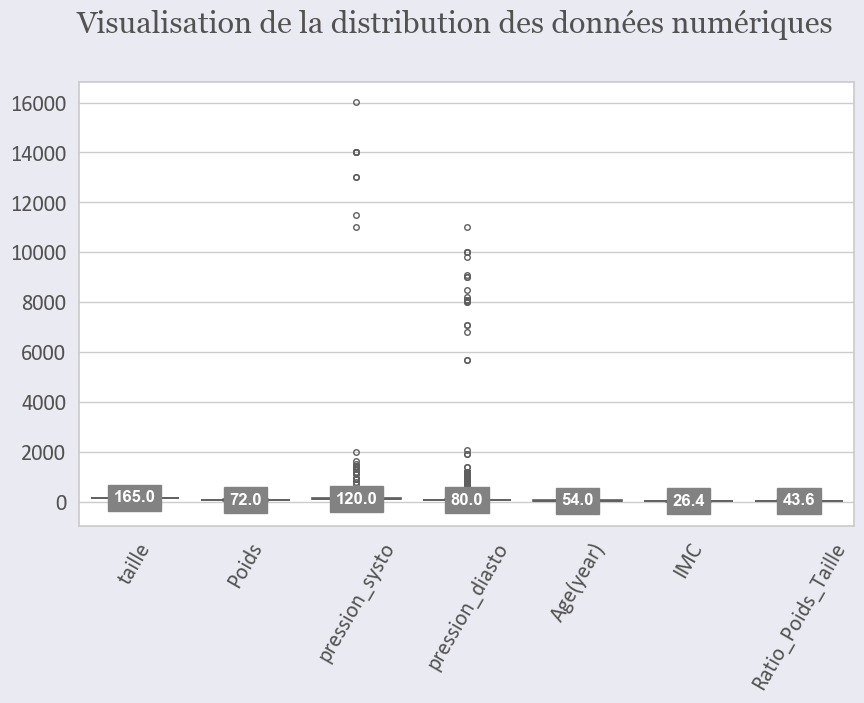

In [15]:
# Boxplot des outliners

var_num = ['taille', 'Poids', 'pression_systo', 'pression_diasto', "Age(year)", 'IMC', "Ratio_Poids_Taille"]
maladie[var_num] = maladie[var_num].apply(pd.to_numeric, errors='coerce', axis=1)

sns.set(style='whitegrid')
facecolor = '#eaeaf2'
fig, ax = plt.subplots(figsize=(10, 6), facecolor=facecolor)

x = sns.boxplot(data=maladie,
                       palette='Set3',
                       linewidth=1.2,
                       fliersize=2,
                       order=['taille', 'Poids', 'pression_systo', 'pression_diasto', "Age(year)",'IMC', "Ratio_Poids_Taille"],
                       flierprops=dict(marker='o', markersize=4))

font_color = '#525252'
csfont = {'fontname':'Georgia'}
hfont = {'fontname':'Calibri'}

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set(fontsize=16, color=font_color, **hfont)

title = 'Visualisation de la distribution des données numériques'
fig.suptitle(title, y=.97, fontsize=22, color=font_color, **csfont)
plt.subplots_adjust(top=0.85)

for i, box in enumerate(ax.artists):
         col = box.get_facecolor()
         plt.setp(ax.lines[i*6+5], mfc=col, mec=col)

lines = ax.get_lines()
categories = ax.get_xticks()

for cat in categories:
    y = round(lines[4+cat*6].get_ydata()[0],1)
    ax.text(
        cat,
        y,
        f'{y}',
        ha='center',
        va='center',
        fontweight='semibold',
        size=12,
        color='white',
        bbox=dict(facecolor='#828282', edgecolor='#828282')
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=60)

plt.show()

In [16]:
maladie["IMC"].mean()

27.557610036546496

Suppression des outliners

In [17]:
out_filter = ((maladie["pression_systo"]>250) | (maladie["pression_diasto"]>200))
maladie = maladie[~out_filter]
out_filter2 = ((maladie["pression_systo"] < 0) | (maladie["pression_diasto"] < 0))
maladie = maladie[~out_filter2]
out_filter3 = ((maladie["taille"] > 200))
maladie = maladie[~out_filter3]
out_filter4 = ((maladie["IMC"] > 200))
maladie = maladie[~out_filter4]

C:\Users\alain\AppData\Local\Temp\ipykernel_3684\2417649260.py:49: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



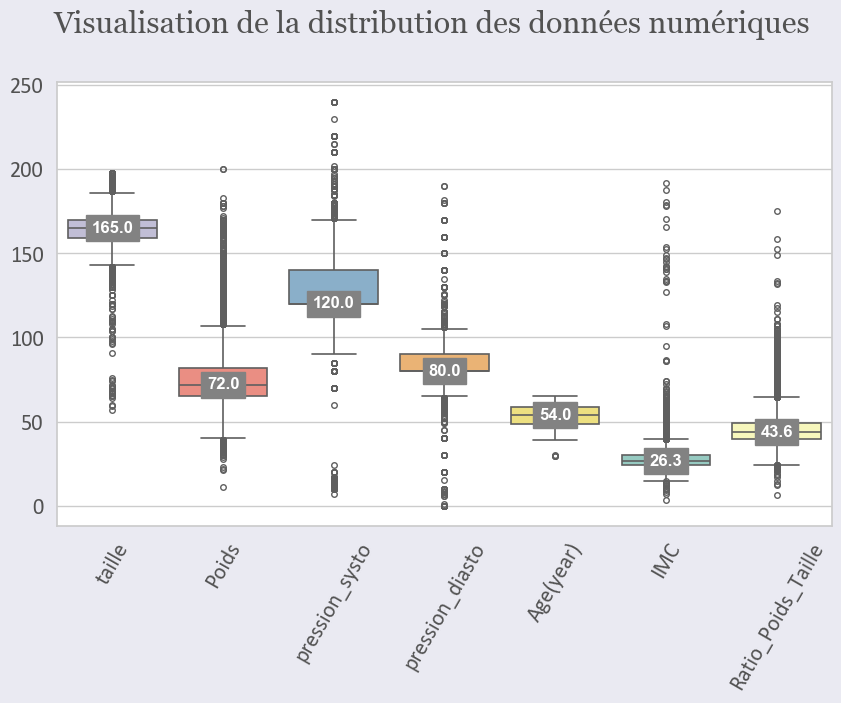

In [18]:
# Boxplot des outliners

var_num = ['taille', 'Poids', 'pression_systo', 'pression_diasto', "Age(year)", 'IMC', "Ratio_Poids_Taille"]
maladie[var_num] = maladie[var_num].apply(pd.to_numeric, errors='coerce', axis=1)

sns.set(style='whitegrid')
facecolor = '#eaeaf2'
fig, ax = plt.subplots(figsize=(10, 6), facecolor=facecolor)

x = sns.boxplot(data=maladie,
                       palette='Set3',
                       linewidth=1.2,
                       fliersize=2,
                       order=['taille', 'Poids', 'pression_systo', 'pression_diasto', "Age(year)",'IMC', "Ratio_Poids_Taille"],
                       flierprops=dict(marker='o', markersize=4))

font_color = '#525252'
csfont = {'fontname':'Georgia'}
hfont = {'fontname':'Calibri'}

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set(fontsize=16, color=font_color, **hfont)

title = 'Visualisation de la distribution des données numériques'
fig.suptitle(title, y=.97, fontsize=22, color=font_color, **csfont)
plt.subplots_adjust(top=0.85)

for i, box in enumerate(ax.artists):
         col = box.get_facecolor()
         plt.setp(ax.lines[i*6+5], mfc=col, mec=col)

lines = ax.get_lines()
categories = ax.get_xticks()

for cat in categories:
    y = round(lines[4+cat*6].get_ydata()[0],1)
    ax.text(
        cat,
        y,
        f'{y}',
        ha='center',
        va='center',
        fontweight='semibold',
        size=12,
        color='white',
        bbox=dict(facecolor='#828282', edgecolor='#828282')
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=60)

plt.show()

In [19]:
maladie.shape

(68969, 18)

In [20]:
maladie.head()

,age,genre,taille,Poids,pression_systo,pression_diasto,cholesterol,glycemie,fumeur,conso_alco,activite_physique,malade,Age(year),IMC,IMC_Categorie,Age_Categorie,Ratio_Poids_Taille,Pression_Arterielle_Categorie
id,,,,,,,,,,,,,,,,,,
0,18393,1,168.0,62.0,110.0,80.0,normal,1,1,0,1,0,50.391781,21.967120,Normal,51-70,36.904762,Inconnu
1,20228,0,156.0,85.0,140.0,90.0,tres eleve,1,1,0,1,1,55.419178,34.927679,Obèse,51-70,54.487179,Hypertension
2,18857,0,165.0,64.0,130.0,70.0,tres eleve,1,1,0,0,1,51.663014,23.507805,Normal,51-70,38.787879,Hypertension Légère
3,17623,1,169.0,82.0,150.0,100.0,normal,1,1,0,1,1,48.282192,28.710479,Surpoids,36-50,48.520710,Hypertension
4,17474,0,156.0,56.0,100.0,60.0,normal,1,1,0,0,0,47.873973,23.011177,Normal,36-50,35.897436,Hypotension Légère


# DataViz

Distribution des maladies cardiaques ou non

C:\Users\alain\AppData\Local\Temp\ipykernel_3684\1094622961.py:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\alain\AppData\Local\Temp\ipykernel_3684\1094622961.py:14: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



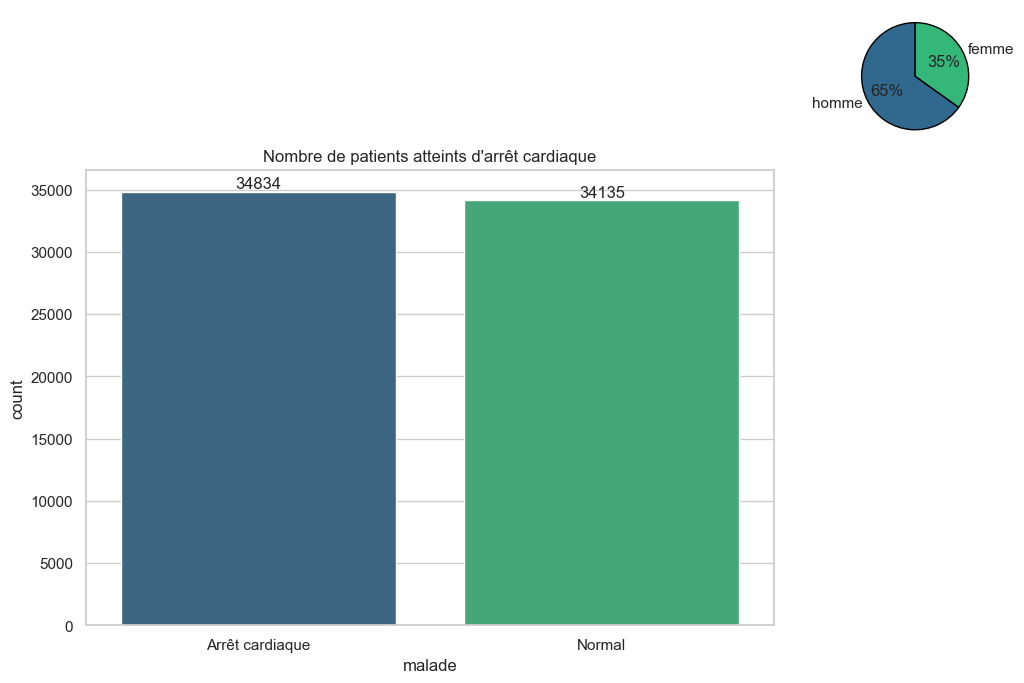

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
gs = plt.GridSpec(4, 4)

# Tracé du graphique principal (histogramme)
ax2 = plt.subplot(gs[1:, :-1])
palette = sns.color_palette("viridis", 2)
sns.countplot(x='malade', data=maladie, ax=ax2, palette=palette)
for i, j in enumerate(maladie['malade'].value_counts().values):
    ax2.text(i, j, str(j), ha='center', va='bottom', fontsize=12)
ax2.set(title="Nombre de patients atteints d'arrêt cardiaque")
ax2.set_xticklabels(["Arrêt cardiaque", "Normal"])

# Tracé du diagramme circulaire (en petit)
ax1 = plt.subplot(gs[0, -1])

gender_labels = label_encoder_sex.inverse_transform(maladie['genre'].unique())
ax1.pie(maladie['genre'].value_counts(), labels=gender_labels, autopct="%1.0f%%", startangle=90, colors=palette, wedgeprops={'edgecolor': 'black'})
plt.show()


C:\Users\alain\AppData\Local\Temp\ipykernel_3684\2492981096.py:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




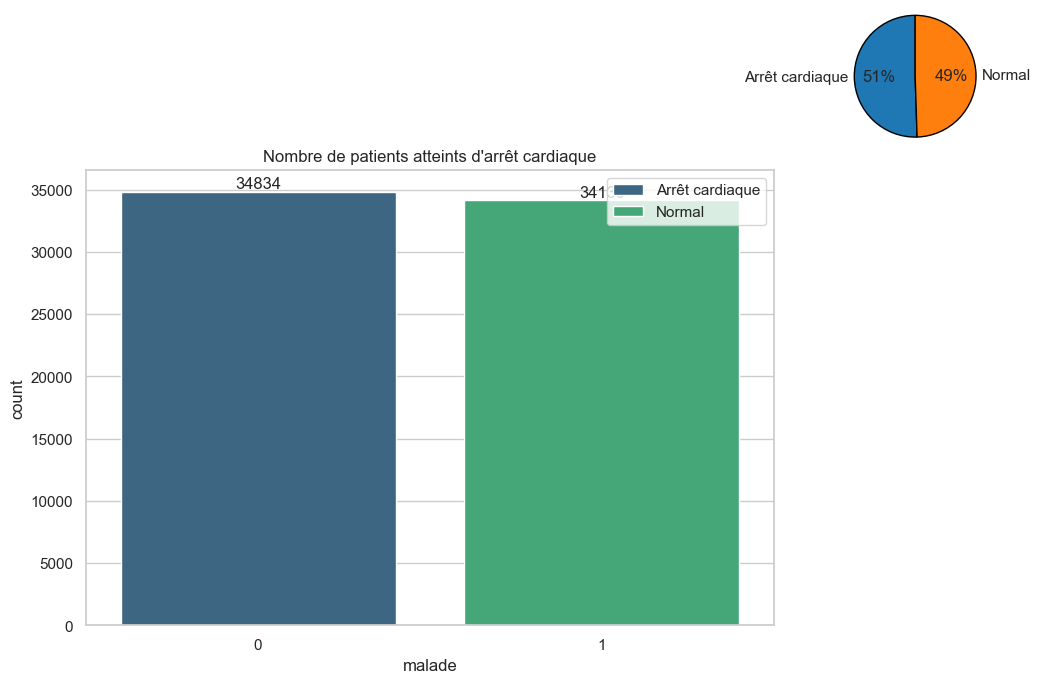

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Création de la figure et des sous-graphiques
plt.figure(figsize=(12, 8))
gs = plt.GridSpec(4, 4)

# Tracé du graphique principal (histogramme)
ax2 = plt.subplot(gs[1:, :-1])
sns.countplot(x='malade', data=maladie, ax=ax2, palette="viridis")
for i, j in enumerate(maladie['malade'].value_counts().values):
    ax2.text(i, j, str(j), ha='center', va='bottom', fontsize=12)
ax2.set(title="Nombre de patients atteints d'arrêt cardiaque")
ax2.legend(labels=["Arrêt cardiaque", "Normal"])

# Tracé du diagramme circulaire (en petit)
ax1 = plt.subplot(gs[0, -1])
colors = ['#1f77b4', '#ff7f0e']  # Couleurs pour le diagramme circulaire
ax1.pie(maladie['malade'].value_counts(), labels=["Arrêt cardiaque", "Normal"], autopct="%1.0f%%", startangle=90, colors=colors, wedgeprops={'edgecolor': 'black'})

# Réglage de l'apparence du deuxième graphique
ax1.axis('equal')  # Pour que le diagramme circulaire soit parfaitement circulaire
plt.show()


In [23]:
# Création de l'histogramme
fig = px.histogram(maladie, x="Age(year)", nbins=30, title="Distribution de l'âge")

# Ajustements esthétiques
fig.update_traces(marker_color='skyblue', marker_line_color='black', marker_line_width=1, opacity=0.7)

# Ajustements de la mise en page
fig.update_layout(xaxis_title="Âge (années)", yaxis_title="Nombre", showlegend=False,
                  bargap=0.05, plot_bgcolor='rgba(0,0,0,0)', margin=dict(l=50, r=50, t=50, b=50))

# Affichage du graphique
fig.show()


Distribution de l'âge

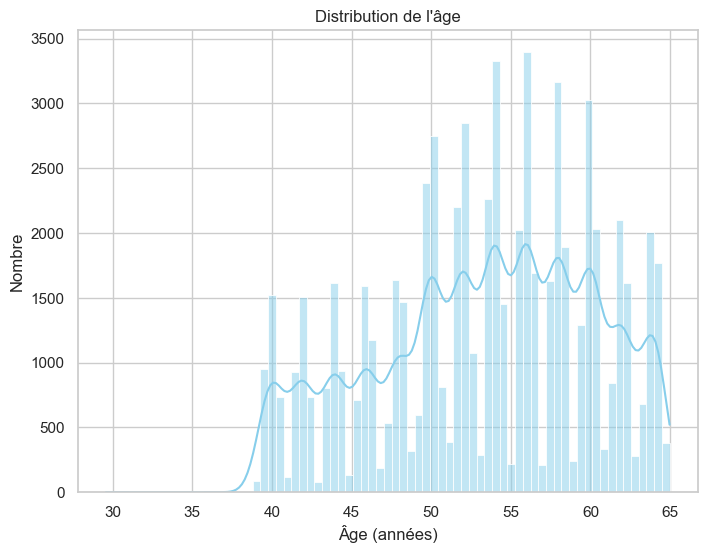

In [24]:
plt.figure(figsize=(8, 6))  # Ajustement de la taille de la figure

# Création du subplot avec seaborn
ax = plt.subplot(111)  # Utilisation d'un seul subplot pour ce tracé
sns.histplot(maladie['Age(year)'], ax=ax, kde=True, color='skyblue')  # Ajout d'un kernel density estimate (KDE) pour une meilleure visualisation de la distribution
plt.title("Distribution de l'âge")  # Ajout d'un titre descriptif

# Ajout de labels pour les axes
plt.xlabel("Âge (années)")
plt.ylabel("Nombre")

# Ajout de la grille pour une meilleure lisibilité
plt.grid(True)

plt.show()

Répartition par genre

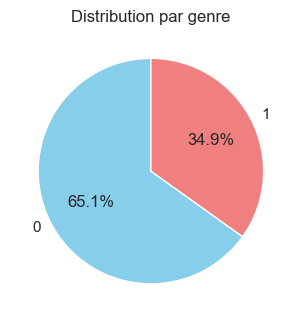

In [25]:
plt.figure(figsize=(8, 6))  # Ajustement de la taille de la figure

# Création du subplot
plt.subplot(121)  # Utilisation d'un seul subplot pour ce tracé
plt.title("Distribution par genre")  # Ajout d'un titre descriptif

# Création du diagramme circulaire avec des couleurs personnalisées
colors = ['skyblue', 'lightcoral', 'lightgreen']
plt.pie(maladie['genre'].value_counts(), labels=maladie['genre'].value_counts().index, autopct='%1.1f%%', startangle=90, colors=colors)

plt.show()


In [26]:
maladie.head()

,age,genre,taille,Poids,pression_systo,pression_diasto,cholesterol,glycemie,fumeur,conso_alco,activite_physique,malade,Age(year),IMC,IMC_Categorie,Age_Categorie,Ratio_Poids_Taille,Pression_Arterielle_Categorie
id,,,,,,,,,,,,,,,,,,
0,18393,1,168.0,62.0,110.0,80.0,normal,1,1,0,1,0,50.391781,21.967120,Normal,51-70,36.904762,Inconnu
1,20228,0,156.0,85.0,140.0,90.0,tres eleve,1,1,0,1,1,55.419178,34.927679,Obèse,51-70,54.487179,Hypertension
2,18857,0,165.0,64.0,130.0,70.0,tres eleve,1,1,0,0,1,51.663014,23.507805,Normal,51-70,38.787879,Hypertension Légère
3,17623,1,169.0,82.0,150.0,100.0,normal,1,1,0,1,1,48.282192,28.710479,Surpoids,36-50,48.520710,Hypertension
4,17474,0,156.0,56.0,100.0,60.0,normal,1,1,0,0,0,47.873973,23.011177,Normal,36-50,35.897436,Hypotension Légère


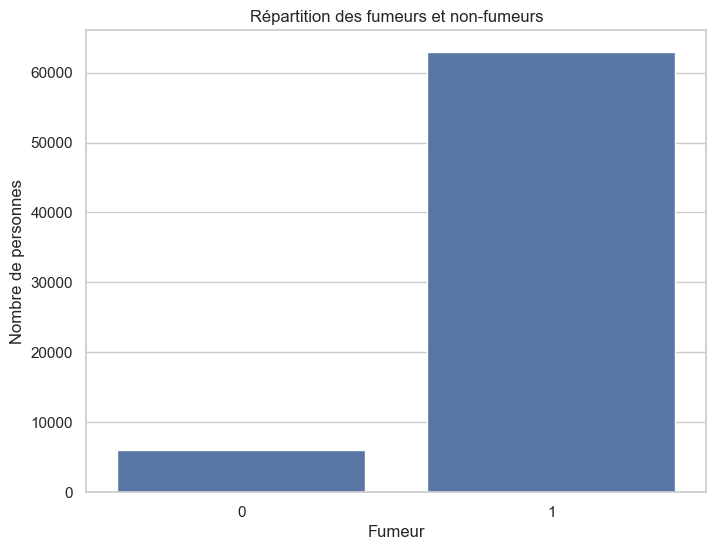

In [27]:
# Diagramme en barres de fumeurs et non-fumeurs
plt.figure(figsize=(8, 6))
sns.countplot(x='fumeur', data=maladie)
plt.title('Répartition des fumeurs et non-fumeurs')
plt.xlabel('Fumeur')
plt.ylabel('Nombre de personnes')
plt.show()

# Variables d'intérêt

RFE

In [28]:
#linmodel = LinearRegression()
#rfe1 = RFE(estimator=linmodel,n_features_to_select=7,step=1,verbose=3)
#rfe1.fit(x_train,y_train)
#
#var_sel = rfe1.get_support()
#
#plt.matshow(var_sel.reshape(1,-1), cmap = 'gray_r')
#plt.xlabel('Feature selection')
#plt.yticks([]);

# Modèle IA

KNN

In [29]:
maladie.head()

,age,genre,taille,Poids,pression_systo,pression_diasto,cholesterol,glycemie,fumeur,conso_alco,activite_physique,malade,Age(year),IMC,IMC_Categorie,Age_Categorie,Ratio_Poids_Taille,Pression_Arterielle_Categorie
id,,,,,,,,,,,,,,,,,,
0,18393,1,168.0,62.0,110.0,80.0,normal,1,1,0,1,0,50.391781,21.967120,Normal,51-70,36.904762,Inconnu
1,20228,0,156.0,85.0,140.0,90.0,tres eleve,1,1,0,1,1,55.419178,34.927679,Obèse,51-70,54.487179,Hypertension
2,18857,0,165.0,64.0,130.0,70.0,tres eleve,1,1,0,0,1,51.663014,23.507805,Normal,51-70,38.787879,Hypertension Légère
3,17623,1,169.0,82.0,150.0,100.0,normal,1,1,0,1,1,48.282192,28.710479,Surpoids,36-50,48.520710,Hypertension
4,17474,0,156.0,56.0,100.0,60.0,normal,1,1,0,0,0,47.873973,23.011177,Normal,36-50,35.897436,Hypotension Légère


In [30]:
data_col = maladie[['Age(year)','taille','Poids','pression_systo','pression_diasto','glycemie','activite_physique','fumeur','conso_alco','malade','genre']]
data_col.head()

,Age(year),taille,Poids,pression_systo,pression_diasto,glycemie,activite_physique,fumeur,conso_alco,malade,genre
id,,,,,,,,,,,
0,50.391781,168.0,62.0,110.0,80.0,1,1,1,0,0,1
1,55.419178,156.0,85.0,140.0,90.0,1,1,1,0,1,0
2,51.663014,165.0,64.0,130.0,70.0,1,0,1,0,1,0
3,48.282192,169.0,82.0,150.0,100.0,1,1,1,0,1,1
4,47.873973,156.0,56.0,100.0,60.0,1,0,1,0,0,0


In [31]:
target = data_col['malade']
data = data_col.drop(['malade'],axis=1)
x_train, x_test, y_train, y_test = train_test_split(data, target, random_state = 123, test_size = 0.2)

In [32]:
sc_x = StandardScaler()
x_train = sc_x.fit_transform(x_train)
x_test = sc_x.transform(x_test)

C:\Users\alain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:767: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\alain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\alain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\alain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra

In [33]:
math.sqrt(len(y_test))

117.44786077234443

In [34]:
param_grid = {
    'n_neighbors': [60, 80, 120],  # ajustez cette plage selon vos besoins
    'p': [1, 2],  # Norme de distance (1 pour la distance de Manhattan, 2 pour la distance euclidienne)
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute']
}

# Créer un classifieur KNN
knn = KNeighborsClassifier()

# Effectuer une recherche par validation croisée
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

In [35]:
grid_search.fit(x_train[:5000], y_train[:5000])
#grid_search.fit(x_train, y_train)

C:\Users\alain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\alain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\alain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\alain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra

C:\Users\alain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\alain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [60, 80, 120], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [36]:
# Afficher les meilleurs paramètres
print("Meilleurs paramètres:", grid_search.best_params_)
print("Meilleurs estimateurs:", grid_search.best_estimator_)

Meilleurs paramètres: {'algorithm': 'ball_tree', 'n_neighbors': 60, 'p': 1, 'weights': 'distance'}
Meilleurs estimateurs: KNeighborsClassifier(algorithm='ball_tree', n_neighbors=60, p=1,
                     weights='distance')


In [37]:
# Entraîner le modèle avec les meilleurs paramètres
best_knn = grid_search.best_estimator_
best_knn.fit(x_train, y_train)

C:\Users\alain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\alain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



KNeighborsClassifier(algorithm='ball_tree', n_neighbors=60, p=1,
                     weights='distance')

In [38]:
# Prédire les étiquettes de test
y_train_pred = best_knn.predict(x_train)
y_test_pred = best_knn.predict(x_test)

In [39]:
# Calculer la précision
accuracy = accuracy_score(y_train, y_train_pred)
print("Précision du modèle train avec les meilleurs paramètres:", accuracy)
accuracy = accuracy_score(y_test, y_test_pred)
print("Précision du modèle test avec les meilleurs paramètres:", accuracy)

Précision du modèle train avec les meilleurs paramètres: 0.9997825101948347
Précision du modèle test avec les meilleurs paramètres: 0.7121212121212122


C:\Users\alain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\alain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\alain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\alain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra

In [40]:
cm = confusion_matrix(y_train,y_train_pred)
cm2 = confusion_matrix(y_test,y_test_pred)

C:\Users\alain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\alain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\alain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\alain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra

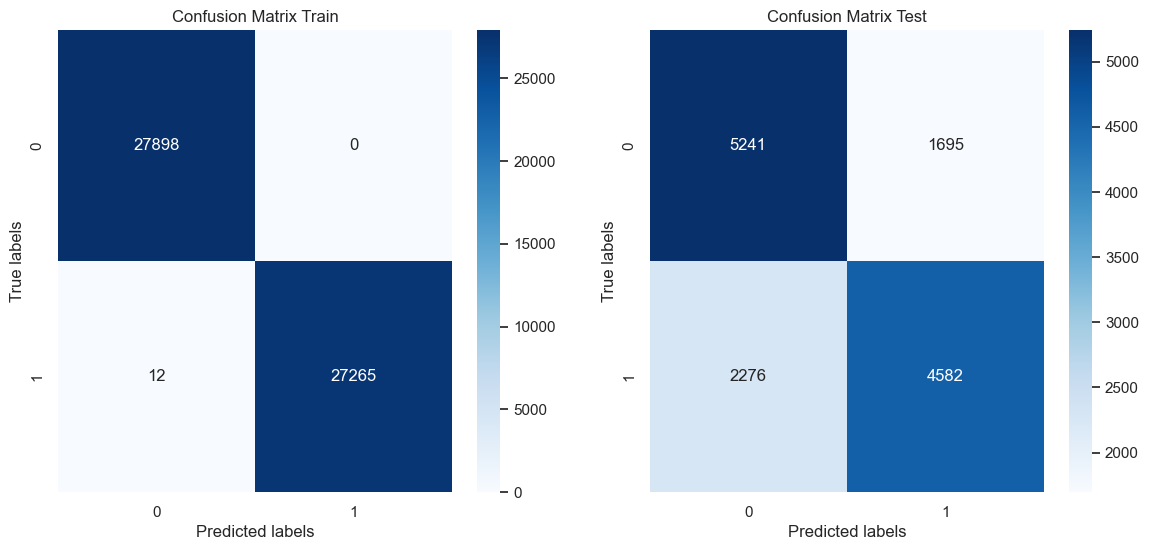

In [41]:
# Afficher la matrice de confusion sous forme de heatmap
plt.figure(figsize=(14, 6))
plt.subplot(121)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix Train')
plt.subplot(122)
sns.heatmap(cm2, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix Test')
plt.show()

In [42]:
TN = cm2[0][0]
FP = cm2[0][1]
FN = cm2[1][0]
TP = cm2[1][1]

score = TN/(TN+FP)
display(score)

0.7556228373702422

In [43]:
x_train.shape[1]

10

In [44]:
from sklearn.model_selection import cross_val_score

# Mesurer les performances du modèle initial
initial_score = np.mean(cross_val_score(best_knn, x_train, y_train, cv=5))

# Initialiser une liste pour stocker les changements de performance
feature_importances = []

# Mesurer l'impact de chaque variable
for feature in range(x_train.shape[1]):
    X_temp = np.delete(x_train, feature, axis=1)  # Supprimer la caractéristique actuelle
    new_score = np.mean(cross_val_score(best_knn, X_temp, y_train, cv=5))
    importance = initial_score - new_score
    feature_importances.append((feature, importance))


# Trier le résultat par ordre décroissant d'importance
feature_importances.sort(key=lambda x: x[1], reverse=True)

# Afficher les importances
for feature, importance in feature_importances:
    print(f"{feature}: {importance}")


C:\Users\alain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\alain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\alain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\alain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra

3: 0.03452650657000467
0: 0.03320344358858196
2: 0.019737199818758544
1: 0.00969642048029018
4: 0.002809243316719612
6: 0.0023380154055280267
9: 0.001196193928409639
5: 0.0003081105573178311
8: -0.00010874490258272473
7: -0.00047122791119158514


C:\Users\alain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\alain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\alain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\alain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra

On cherche à déterminer si le patient est réellement malade. Ce qui importe ici, c'est de savoir s'il est effectivement malade et non pas s'il ne l'est pas.